# Continuous time Markov processes, Gillespie algorithm

In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy import integrate

The Gillespie algorithm is a powerful tool for simulating stochastic trajectories of continuous-time Markov processes. The algorithm generates trajectories that represent the time evolution of a system by producing a sequence of states $(C_0, C_1, \dots, C_N)$ and their corresponding residence times $(t_0, t_1, \dots, t_N)$. The key steps in the Gillespie algorithm are:

1. **Compute the time of the next reaction**: the time until the next reaction, $\tau$, is sampled from an exponential distribution $p(\tau) = \lambda_C \exp{(-\lambda_C \tau)}$, where $\lambda_C$ is the total reaction rate, defined as the sum of all individual reaction rates at that state $C$.

2. **Determine which reaction occurs**: to choose which reaction will occur next, a random number $u$ is sampled from a uniform distribution on $[0, 1]$. The reaction is selected by comparing $u$ with the cumulative sum of the normalized reaction rates $w_j/\lambda_C$, where $w_j$ is the rate of the $j$th reaction. The reaction corresponding to the cumulative sum that first exceeds $u$ is selected.

By repeating these steps for each reaction, the Gillespie algorithm constructs a trajectory that accurately captures the stochastic dynamics of the system. Unlike deterministic mean-field methods, which average out fluctuations, the Gillespie algorithm preserves the inherent stochasticity of the process, providing a more realistic simulation of systems where fluctuations play a significant role.

## 7.1 Lokta-Volterra

The Lotka-Volterra model, often referred to as the predator-prey model, is represented by the following system of odes:

$$
\begin{cases}
\frac{\partial{x(t)}}{\partial t} = k_1 x(t) - k_2 x(t)y(t) \\
\frac{\partial{y(t)}}{\partial t} = k_2 x(t)y(t) - k_3 y(t)
\end{cases}
$$

Here, $x(t)$ denotes the prey population, and $y(t)$ represents the predator population. The parameter $k_1$ is the birth rate of the prey, $k_2$ quantifies the interaction between predators and prey, leading to the birth of a predator and the death of a prey, and $k_3$ is the death rate of the predators.

This model is the mean-field approximation of a stochastic process described by the following reactions:

$$
\begin{align}
(x, y) &\rightarrow (x + 1, y) \quad \text{with } w_1 = k_1 x \\
(x, y) &\rightarrow (x - 1, y + 1) \quad \text{with } w_2 = k_2 x y \\
(x, y) &\rightarrow (x, y - 1) \quad \text{with } w_3 = k_3 y
\end{align}
$$

The fixed points of the deterministic model, $(x^*_1, y^*_1) = (0, 0)$ and $(x^*_2, y^*_2)$, correspond to different dynamical behaviors:

- At $(x^*_1, y^*_1) = (0, 0)$, the system is in a saddle point, which is unstable.
- At $(x^*_2, y^*_2) = (\frac{k_3}{k_2}, \frac{k_1}{k_2})$, the system shows stable oscillations in the deterministic case, but in the stochastic model, these oscillations can vary in amplitude, potentially leading to extinction events.

The Jacobian matrices at these points are:

$$
\begin{align}
J(0, 0) = 
\begin{bmatrix}
k_1 & 0 \\
0 & -k_3 
\end{bmatrix} 
\qquad &\text{eigenvalues: } (k_1, -k_3) \rightarrow \text{ saddle point (unstable)} \\
J\left(\frac{k_3}{k_2},\frac{k_1}{k_2}\right) = 
\begin{bmatrix}
0 & -k_3 \\
k_1 & 0 
\end{bmatrix} 
\qquad &\text{eigenvalues: } (\pm i\sqrt{k_1 k_3}) \rightarrow \text{ stable point with oscillations}
\end{align}
$$

In [2]:
def gillespie_LV(N, c0, r_step, k1, k2, k3):
    
    # initialize the array that contain all the configurations
    C = np.zeros(shape=(N, (r_step+1)))
    # initialize the array that contains all the times in which interactions occur
    react_times = np.zeros(shape=((r_step+1),1))
    
    # initial conditions
    C[:,0] = c0
    react_times[0] = 0
    
    # gillespie for each time step
    for i in range(r_step):
        t = i+1 # we have insterted react_times[0] = 0, we start the loop from t = 1
        
        # rate computation for lockta-volterra
        w1 = k1*C[0,t-1]  
        w2 = k2*C[0,t-1]*C[1,t-1]
        w3 = k3*C[1,t-1]
        w = [w1,w2,w3] # aggregation
        # lambda is the sum of all the possible reaction rates at a specific time step
        lambda_C = sum(w)
        
        # sample waiting time from p_C(t) = lambda*exp(-lambda*t) 
        tau = np.random.exponential(scale=1/lambda_C, size=1)
        react_times[t] = react_times[t-1]+tau # collection of reaction times
        
        # randomly choose a state j where to jump
        u = np.random.rand()
        # Find random index: we confront the random value u with the cumulative sum of the probability distribution of rates
        i = 0
        p_sum = 0.0
        while p_sum < u:
            p_sum += w[i]/lambda_C # lambda_C for normalization (p in [0,1])
            i += 1
        reaction_idx = i-1
        
        # compact increment identification for lockta-volterra
        x = 0 if reaction_idx==2 else (-1)**reaction_idx
        y = -1 if reaction_idx==2 else reaction_idx
        C[0, t] = C[0, t-1] + x
        C[1, t] = C[1, t-1] + y
        
    return C, react_times

# the following function implements the ode system for lockta-volterra mean field approx model
def lockta_volterra(X, t, k1, k2, k3):
    x, y = X
    dotx = x * (k1 - k2 * y)
    doty = y * (-k3 + k2 * x)
    return np.array([dotx, doty])

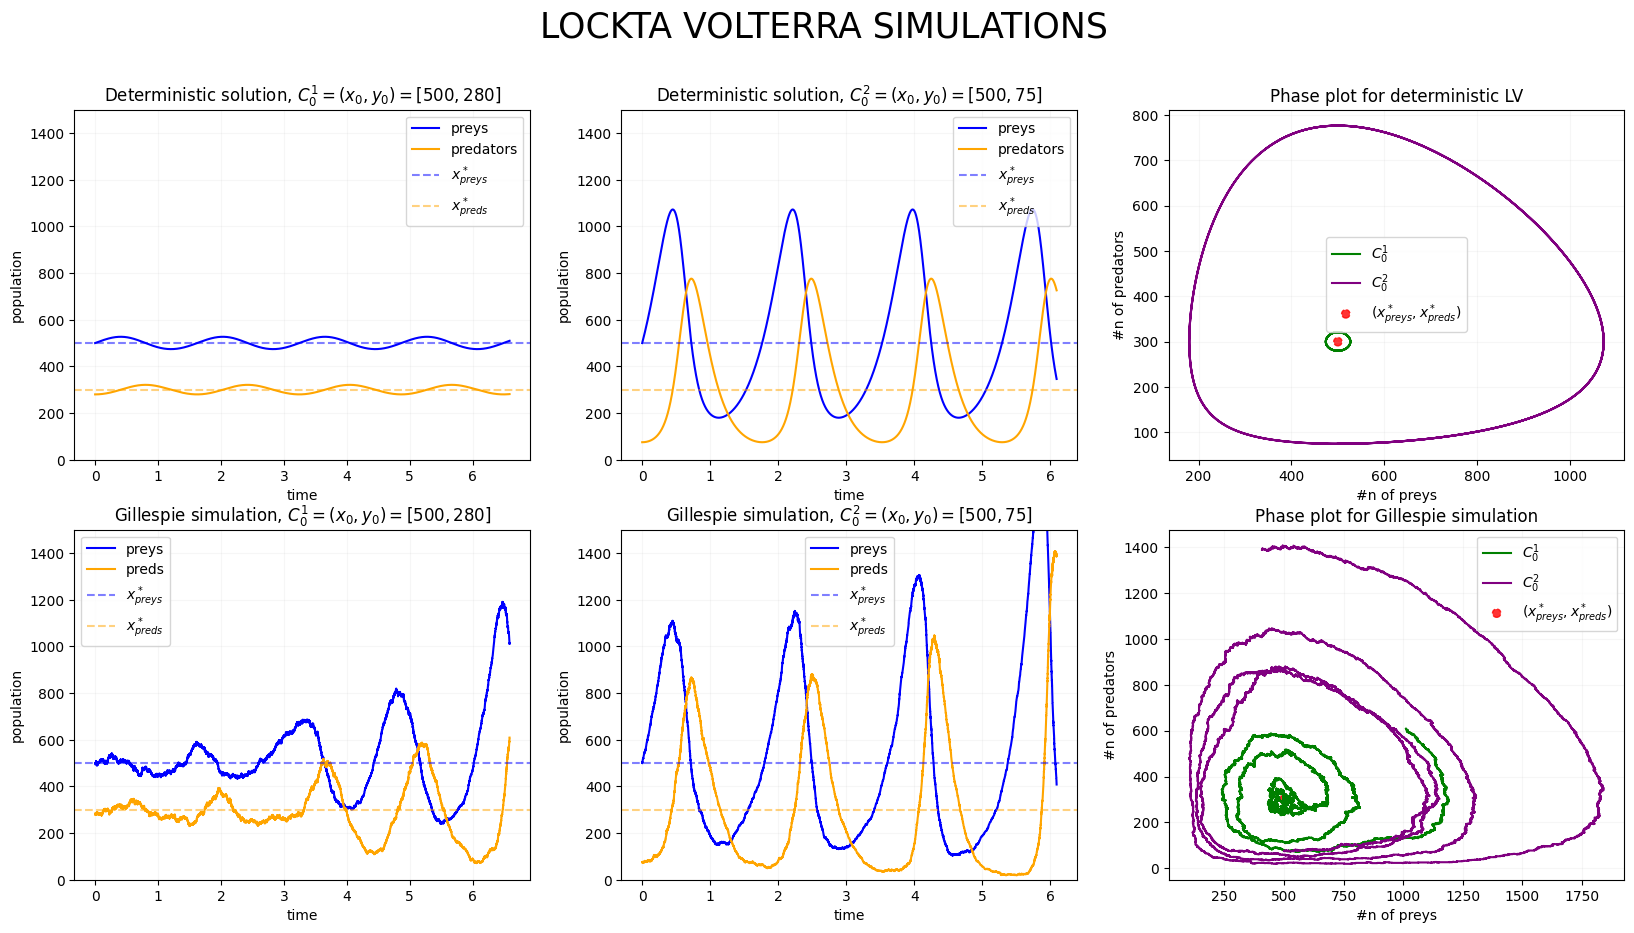

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=3,figsize=(20,10))
plt.suptitle("LOCKTA VOLTERRA SIMULATIONS", fontsize=25)

# parameters
N = 2 # number of populations
r_step = 30000 # reaction steps

# constants
k1 = 3
k2 = 1/100
k3 = 5

# initial conditions: values chosen to mirror the results chapter "Continous-time Markov processes" of the lessons
a = [500, 280] # near equilibrium point
b = [500, 75] # far from equilibrium point

# computation for initial conditions near equilibrium point
C1, react_times1 = gillespie_LV(N, a, r_step, k1, k2, k3)

# computation for initial conditions far from equilibrium point
C2, react_times2 = gillespie_LV(N, b, r_step, k1, k2, k3)

# numerical results of mean field system with the same parameters
t1 = np.squeeze(react_times1)
t2 = np.squeeze(react_times2)
# solution for initial conditions near equilibrium point
res1 = integrate.odeint(lockta_volterra, a, t1, args = (k1, k2, k3))
x1, y1 = res1.T
# solution for initial conditions far from equilibrium point
res2 = integrate.odeint(lockta_volterra, b, t2, args = (k1, k2, k3))
x2, y2 = res2.T

# plot everything
ax[0][0].plot(react_times1, x1, label="preys", color="blue")
ax[0][0].plot(react_times1, y1, label="predators", color="orange")
ax[0][0].set_title(r"Deterministic solution, $C_0^1 = (x_0, y_0) = {}$".format(a))
ax[1][0].plot(react_times1, C1[0,:], label="preys", color="blue")
ax[1][0].plot(react_times1, C1[1,:], label="preds", color="orange")
ax[1][0].set_title(r"Gillespie simulation, $C_0^1 = (x_0, y_0) = {}$".format(a))

ax[0][1].plot(react_times2, x2, label="preys", color="blue")
ax[0][1].plot(react_times2, y2, label="predators", color="orange")
ax[0][1].set_title(r"Deterministic solution, $C_0^2 = (x_0, y_0) = {}$".format(b))
ax[1][1].plot(react_times2, C2[0,:], label="preys", color="blue")
ax[1][1].plot(react_times2, C2[1,:], label="preds", color="orange")
ax[1][1].set_title(r"Gillespie simulation, $C_0^2 = (x_0, y_0)  = {}$".format(b))

# plot phase space
ax[0][2].plot(x1, y1, color="green", label=r"$C_0^1$")
ax[0][2].plot(x2, y2, color="purple", label=r"$C_0^2$")
ax[0][2].set_title(r"Phase plot for deterministic LV")
ax[1][2].plot(C1[0,:], C1[1,:], color="green", label=r"$C_0^1$")
ax[1][2].plot(C2[0,:], C2[1,:], color="purple", label=r"$C_0^2$")
ax[1][2].set_title(r"Phase plot for Gillespie simulation")

for i in range(2):
    ax[i][2].scatter(x = k3/k2, y = k1/k2, label=r"$(x^*_{{preys}}, x^*_{{preds}})$", linestyle="--", alpha=0.8, color="red")
    ax[i][2].grid(alpha=0.1)
    ax[i][2].legend(loc="best")
    ax[i][2].set_xlabel("#n of preys")
    ax[i][2].set_ylabel("#n of predators")

for i in range(2):
    for j in range(2):
        ax[i][j].axhline(k3/k2, label=r"$x^*_{{preys}}$", linestyle="--", alpha=0.5, color="blue")
        ax[i][j].axhline(k1/k2, label=r"$x^*_{{preds}}$", linestyle="--", alpha=0.5, color="orange")
        ax[i][j].grid(alpha=0.1)
        ax[i][j].legend(loc="best")
        ax[i][j].set_xlabel("time")
        ax[i][j].set_ylabel("population")
        ax[i][j].set_ylim([0, 1500])

When the initial conditions are near the stable point, the deterministic Lotka-Volterra model shows regular periodic oscillations around this equilibrium, reflecting the stability of the system. Using the Gillespie algorithm, we also observe oscillations; however, these oscillations include random fluctuations due to the stochastic nature of the process that the algorithm captures. In the phase space of the deterministic system, we observe a smooth, regular orbit around the equilibrium point. In contrast, the phase space trajectory generated by the Gillespie algorithm reflects the unpredictability of the process, with cycles that are more irregular and scattered.

When the initial conditions are further from the stable point, both models exhibit larger oscillations around the equilibrium. However, the differences between the deterministic and stochastic models remain: the deterministic model produces smooth, predictable trajectories, while the Gillespie simulation continues to show variability and randomness in the oscillations.

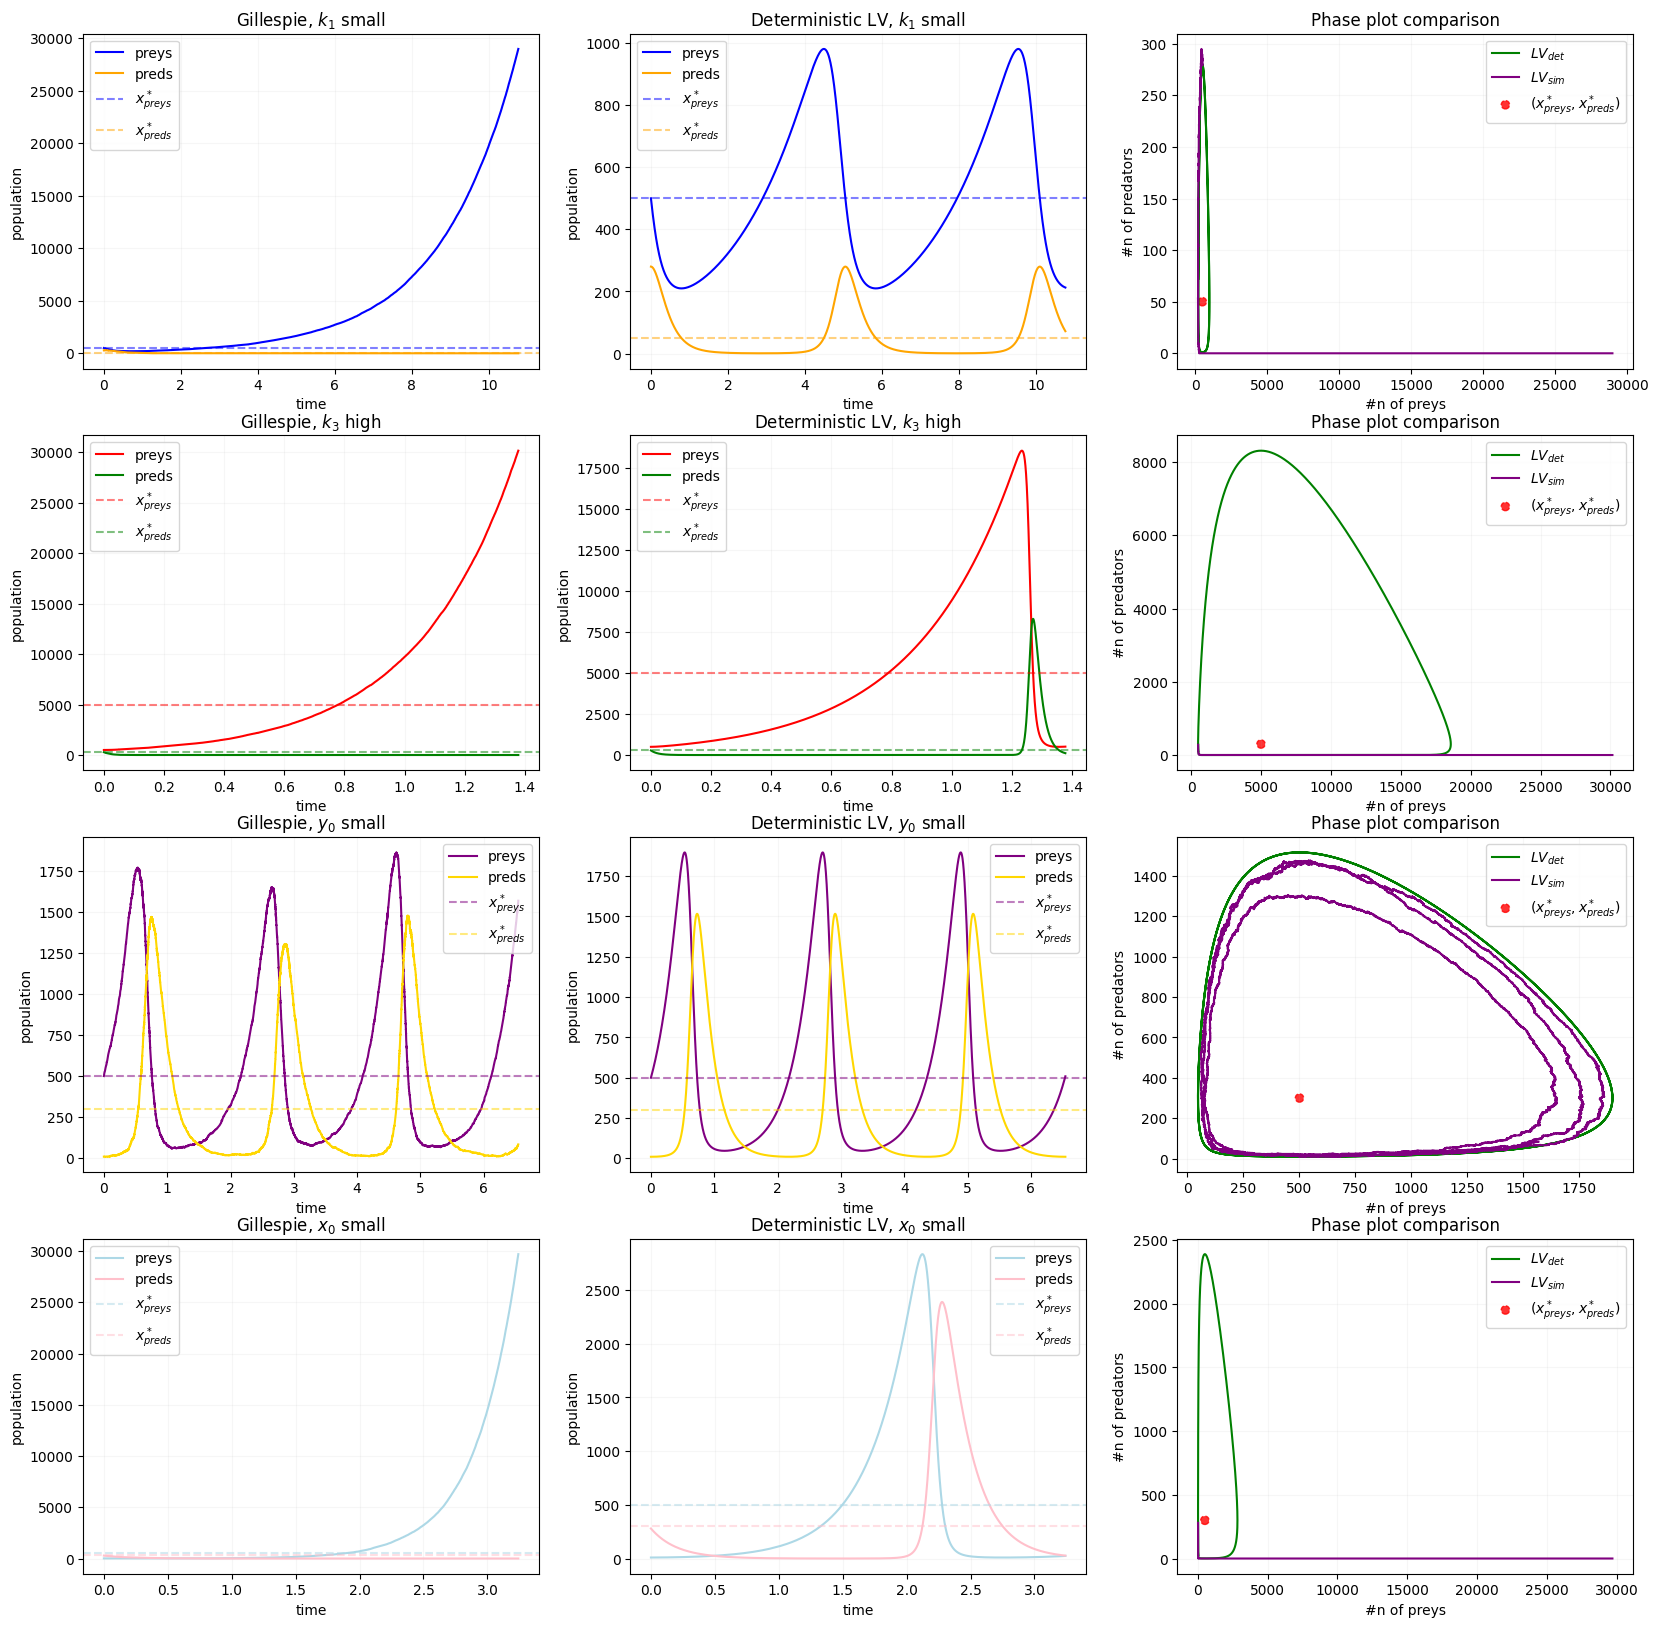

In [25]:
fig, ax = plt.subplots(nrows=4, ncols=3,figsize=(20,20))
# parameters
N = 2 # number of populations
r_step = 30000 # reactions number

colors = ["blue", "orange", "red", "green", "purple", "gold","lightblue","pink"]
titles = ["$k_1$ small", "$k_3$ high", "$y_0$ small", "$x_0$ small"]
# examinate the 4 cases
for i, k in enumerate(titles):
    k1 = 3
    k2 = 1/100
    k3 = 5
    a = [500, 280] 
    if i == 0:
        k1 = 0.5
    elif i == 1:
        k3 = 50
    elif i == 2:
        a = [500, 10] 
    else:
        a = [10, 280]
    
    # computation for initial conditions near equilibrium point
    C1, react_times1 = gillespie_LV(N, a, r_step, k1, k2, k3)
    
    # numerical results of mean field system with the same parameters
    t1 = np.squeeze(react_times1)
    # solution for initial conditions near equilibrium point
    res1 = integrate.odeint(lockta_volterra, a, t1, args = (k1, k2, k3))
    x1, y1 = res1.T
    
    # plot everything
    ax[i][1].plot(react_times1, x1, color=colors[2*i], label="preys")
    ax[i][1].plot(react_times1, y1, color=colors[(2*i)+1], label="preds")
    ax[i][1].set_title(r"Deterministic LV, {}".format(titles[i]))
    ax[i][0].set_title(r"Gillespie, {}".format(titles[i]))
    ax[i][0].plot(react_times1, C1[0,:], label="preys", color=colors[(2*i)])
    ax[i][0].plot(react_times1, C1[1,:], label="preds", color=colors[(2*i)+1])

    # plot phase space
    ax[i][2].plot(x1, y1, color="green", label=r"$LV_{{det}}$")
    ax[i][2].plot(C1[0,:], C1[1,:], color="purple", label=r"$LV_{{sim}}$")
    ax[i][2].set_title(r"Phase plot comparison")
    ax[i][2].scatter(x = k3/k2, y = k1/k2, label=r"$(x^*_{{preys}}, x^*_{{preds}})$", linestyle="--", alpha=0.8, color="red")
    ax[i][2].grid(alpha=0.1)
    ax[i][2].legend(loc="best")
    ax[i][2].set_xlabel("#n of preys")
    ax[i][2].set_ylabel("#n of predators")
    
    for j in range(2):
        ax[i][j].axhline(k3/k2, label=r"$x^*_{{preys}}$", linestyle="--", alpha=0.5, color=colors[2*i])
        ax[i][j].axhline(k1/k2, label=r"$x^*_{{preds}}$", linestyle="--", alpha=0.5, color=colors[(2*i)+1])
        ax[i][j].grid(alpha=0.1)
        ax[i][j].legend(loc="best")
        ax[i][j].set_xlabel("time")
        ax[i][j].set_ylabel("population")
        #ax[i][j].set_ylim([0, 1500])

As observed in the plots above, altering the values of $k_1$, $k_3$ and $x_0$ can lead to the extinction of the predator population and the subsequent uncontrolled growth of the prey population. The conditions tested are as follows:
- $k_1$ small: this scenario represents a low reproduction rate for the prey population. With the prey unable to reproduce quickly enough, the predator population cannot sustain itself and eventually becomes extinct due to a lack of food, leading to the unchecked growth of the remaining prey.
- $k_3$ high: the predator death rate is very high, causing the predators to die off quickly. As a result, the prey population explodes due to the absence of natural predators.
- $y_0$ small: this situation does not provide constant results because they are subjected to random variations in the interactions. For the majority of the realisations (as the one reported on the third row of the plot above), a small initial predators population does not affect the lokta-volterra expected dynamics. For some realisations, however, the small initial population of predators goes extinct, probably due to "unfortunate" multiple death interactions at the beginning of the evolution. However, the number of cases in which this happen is not significant to determine that simply descreasing $y_0$ is possible to have an extinction, it is more safe to claim that the situations in which this happen are more correlated to the previous case ($k_3$ high).
- $x_0$ small: the small initial prey population cannot sustain the predator population, leading to a rapid extinction of the predators. Without the predators, the prey population eventually grows without any constraints.

In the central plots, the solutions of the deterministic ODE systems are also shown. Since the deterministic system is attracted to the stable equilibrium point $(\frac{k_3}{k_2}, \frac{k_1}{k_2})$, it does not exhibit the divergent behavior seen in the stochastic simulations for these parameter values. This suggests that the deterministic model fails to capture the full complexity of natural systems, which are subject to the stochastic nature of interactions.

The phase plots on the right further illustrate the difference between the stochastic and deterministic approaches. The green curve represents the deterministic trajectory, which is always an ellipse around the fixed point of the Lotka-Volterra equations, indicating ongoing oscillations in the population dynamics. In contrast, the purple line, which is horizontal at $y=0$, shows that the predators have gone extinct while the prey population grows unchecked.

## 7.2 Brusselator

The Brusselator is a model used to describe certain chemical reaction systems that exhibit oscillatory behavior. It involves two chemical species, $x$ and $y$, and their interactions are represented through the following four reactions:

$$
\begin{align}
(x, y) &\rightarrow (x + 1, y) \quad \text{with } w_1 = a \Omega \\
(x, y) &\rightarrow (x - 1, y) \quad \text{with } w_2 = x \\
(x, y) &\rightarrow (x + 1, y - 1) \quad \text{with } w_3 = \frac{1}{\Omega^2}x(x-1)y \\
(x, y) &\rightarrow (x - 1, y + 1) \quad \text{with } w_3 = bx \\
\end{align}
$$

$a$ controls the production rate of species $x$, $b$ controls the depletion rate of species $x$ and $\Omega$ represents a parameter that influences the interaction between $x$ and $y$. A larger $\Omega$ decreases the rate of this interaction, while a smaller $\Omega$ increases it, potentially influencing the oscillatory behavior of the system.

In [21]:
def gillespie_B(N, c0, r_step, a, omega, b):
    
    # initialize the array that contain all the configurations
    C = np.zeros(shape=(N, (r_step+1)))
    # initialize the array that contains all the times in which interactions occur
    react_times = np.zeros(shape=((r_step+1),1))
    
    # initial conditions
    C[:,0] = c0
    react_times[0] = 0
    
    # gillespie for each time step
    for i in range(r_step):
        t = i+1 # we have insterted react_times[0] = 0, we start the loop from t = 1
        
        # rate computation for brusselator
        w1 = a*omega
        w2 = C[0,t-1]
        w3 = 1/(omega)**2 * C[0,t-1] * (C[0,t-1] - 1) * C[1,t-1]
        w4 = b * C[0,t-1]
        w = [w1,w2,w3, w4] # aggregation
        # lambda is the sum of all the possible reaction rates at a specific time step
        lambda_C = sum(w)
        
        # sample waiting time from p_C(t) = lambda*exp(-lambda*t) 
        tau = np.random.exponential(scale=1/lambda_C, size=1)
        react_times[t] = react_times[t-1]+tau # collection of reaction times
        
        # randomly choose a state j where to jump
        u = np.random.rand()
        # Find random index: we confront the random value u with the cumulative sum of the probability distribution of rates
        i = 0
        p_sum = 0.0
        while p_sum < u:
            p_sum += w[i]/lambda_C # lambda_C for normalization (p in [0,1])
            i += 1
        reaction_idx = i-1
        
        # compact increment identification for brusselator
        x = 1 if reaction_idx%2==0 else -1
        y = -(-1)**reaction_idx if reaction_idx > 1 else 0
        C[0, t] = C[0, t-1] + x
        C[1, t] = C[1, t-1] + y
        
    return C, react_times

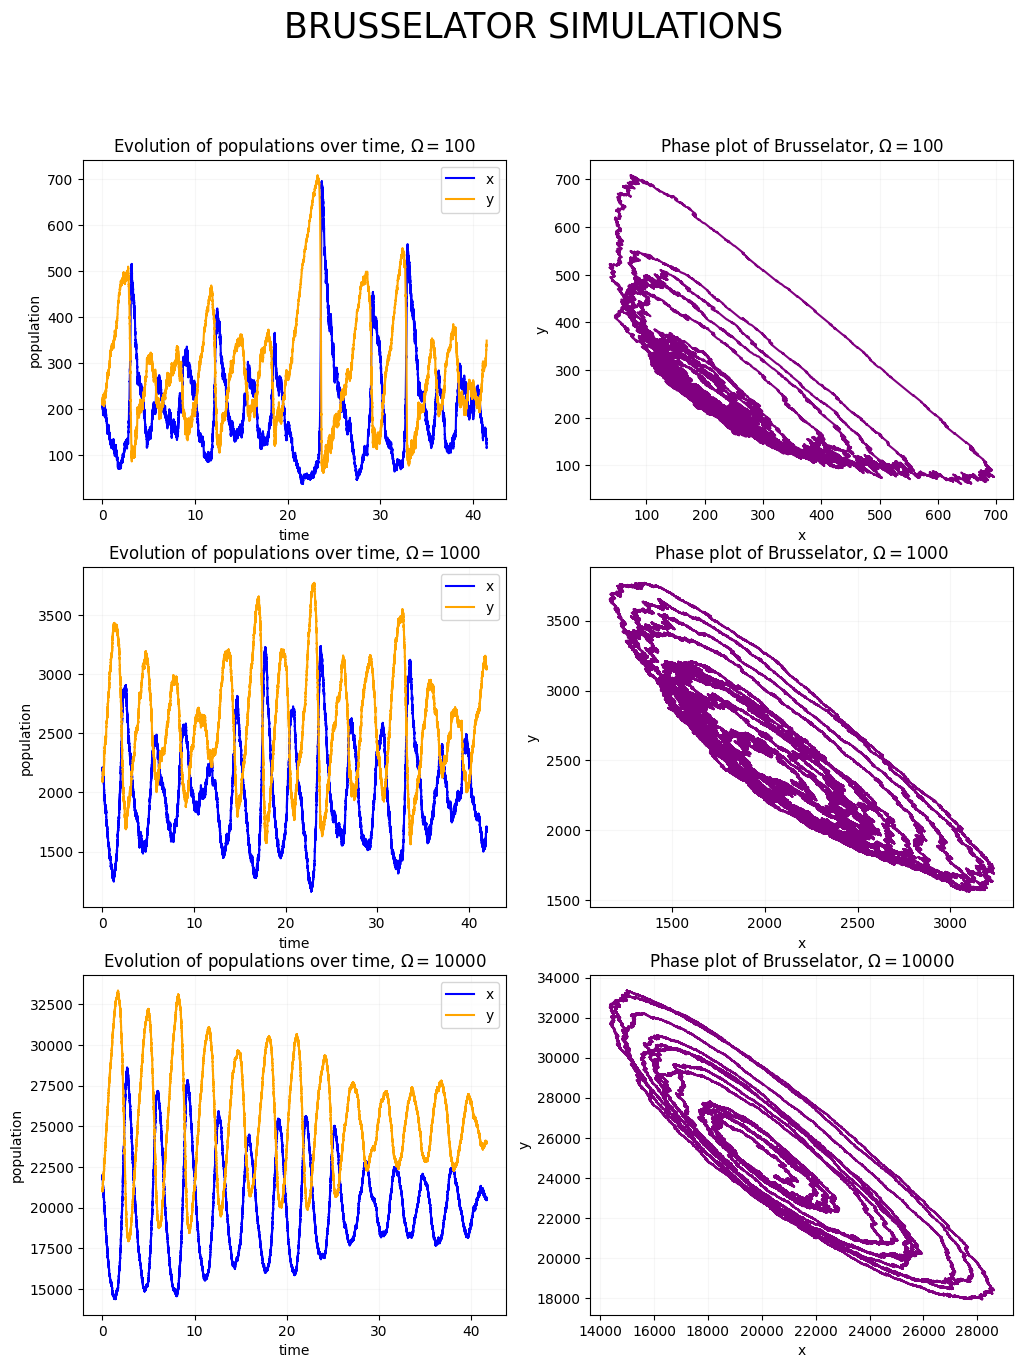

In [22]:
fig, ax = plt.subplots(nrows=3, ncols=2,figsize=(12,15))
plt.suptitle("BRUSSELATOR SIMULATIONS", fontsize=25)

# parameters
N = 2 # number of populations

# constants
a = 2
omega_range = [10**2, 10**3, 10**4]
b = 5

for i, omega in enumerate(omega_range):
    
    # the number of reactions depend on the omega rate
    r_step = 1000*omega

    # initial conditions: values chosen to mirror the results chapter "Continous-time Markov processes" of the lessons
    C0 = [2.2*omega, 2.1*omega] # near equilibrium point
    
    # simulation using gillespie for each omega
    C, react_times = gillespie_B(N, C0, r_step, a, omega, b)
    
    # plot everything
    ax[i][0].plot(react_times, C[0,:], label="x", color="blue")
    ax[i][0].plot(react_times, C[1,:], label="y", color="orange")
    ax[i][0].set_title(r"Evolution of populations over time, $\Omega = {}$".format(omega))
    ax[i][0].set_xlabel("time")
    ax[i][0].set_ylabel("population")
    ax[i][0].legend(loc="best")
    ax[i][1].plot(C[0,:], C[1,:], color="purple")
    ax[i][1].set_xlabel("x")
    ax[i][1].set_ylabel("y")
    ax[i][1].set_title(r"Phase plot of Brusselator, $\Omega = {}$".format(omega))
    
    for j in range(2):
        ax[i][j].grid(alpha=0.1)
        

In the plots, we can observe that as $\Omega$ increases, the oscillations tend to stabilize more quickly. This is because a higher $\Omega$ decreases the rate of the third reaction, $w_3$, which in turn reduces the impact of stochastic fluctuations, making the system more stable. Conversely, when the volume is small, the system becomes more sensitive to stochastic effects due to the reduced number of molecules.

Additionally, the average populations of species $x$ and $y$ are higher for larger $\Omega$. This is because the first reaction, governed by the rate $w_1$, is favored at higher volumes, leading to an overall increase in the population levels of both species.